In [1]:
% pylab inline
import numpy as np
#import numpy
import sklearn
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
from sklearn import ensemble
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


ImportError: No module named sklearn

In [2]:
# Read the full light curves, Q16
lcvs = np.load('Kepler_Spike_Removal_Full_LCs.npy', encoding="latin1")
Observables=np.load('HR_Observables.npy')

IOError: [Errno 2] No such file or directory: 'Kepler_Spike_Removal_Full_LCs.npy'

In [177]:
test[0],Observables[0]

(array(['0', 'kplr008462852', '20 6 15.45 ', ' 44 27 24.75',
        'TYC3162-665-1', '*', '0.78172493', '2.9634886', '0', '0'],
       dtype='<U26'),
 array(['0', 'kplr008462852', '20 6 15.45 ', ' 44 27 24.75',
        'TYC3162-665-1', '*'], dtype='<U26'))

In [3]:
a = 0
b = len(lcvs[0][0])
fluxes = []
for i in arange(2500):
    #plt.scatter(lcvs[i][0][a:b],lcvs[i][1][a:b],s=0.1)
    time = lcvs[i][0][a:b]
    flux = lcvs[i][1][a:b]
    flux_unc = lcvs[i][2][a:b]
    fluxes.append(flux)

fluxes = np.array(fluxes)
print(shape(fluxes))
obj_ids = numpy.arange(len(fluxes))

(2500, 3534)


# Creates Periodograms

In [4]:
from scipy import signal
from astropy.stats import LombScargle
from matplotlib import rc
a = 300 #0
b = len(lcvs[0][0])
periodograms1 = []
frequencies1 = []
for i in arange(2500):
    #plt.scatter(lcvs[i][0][a:b],lcvs[i][1][a:b],s=0.1)
    time = lcvs[i][0][a:b]
    flux = lcvs[i][1][a:b]
    flux_unc = lcvs[i][2][a:b]
    f, Pxx_den = LombScargle(time,flux,flux_unc).autopower()
    #print(len(f[(f>48.0) & (f<50.0)]),len(Pxx_den[(f>48.0) & (f<50.0)]))
    f_interp = np.linspace(26.,49.,1000)
    #f_interp = np.linspace(0.058963575667597946,60.52043743981001,600)
    Pxx_interp = np.interp(f_interp,f,Pxx_den)
    periodograms1.append(Pxx_interp)
    frequencies1.append(f_interp)
    #xlim(48.0,50.0)
    #ylim(0,1)

In [5]:
print(np.shape(periodograms1))
print(np.shape(frequencies1))
print(np.shape(fluxes))

(2500, 1000)
(2500, 1000)
(2500, 3534)


In [6]:
# Combines both the flux and Periodogram values as a single set of features for each LC.
periodograms = np.concatenate((fluxes,periodograms1),axis=1)
print(shape(periodograms))

(2500, 4534)


Text(0,0.5,'PSD [V**2/freq_units]')

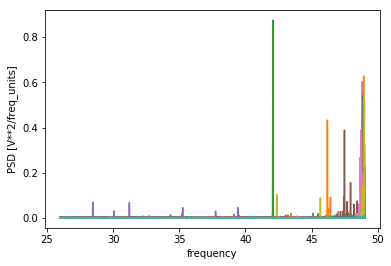

In [8]:
for i in arange(100): 
    #print(i)
    plt.plot(frequencies1[i], periodograms1[i])
#xlim(45,50)
#ylim(0,0.65)
plt.xlabel('frequency')
plt.ylabel('PSD [V**2/freq_units]')

In [10]:
def return_synthetic_data(X):
    """
    The function returns a matrix with the same dimensions as X but with synthetic data
    based on the marginal distributions of its featues
    """
    features = len(X[0])
    X_syn = numpy.zeros(X.shape)

    for i in range(features):
        obs_vec = X[:,i]
        syn_vec = numpy.random.choice(obs_vec, len(obs_vec)) # here we chose the synthetic data to match the marginal distribution of the real data
        X_syn[:,i] += syn_vec

    return X_syn

X_syn = return_synthetic_data(periodograms)

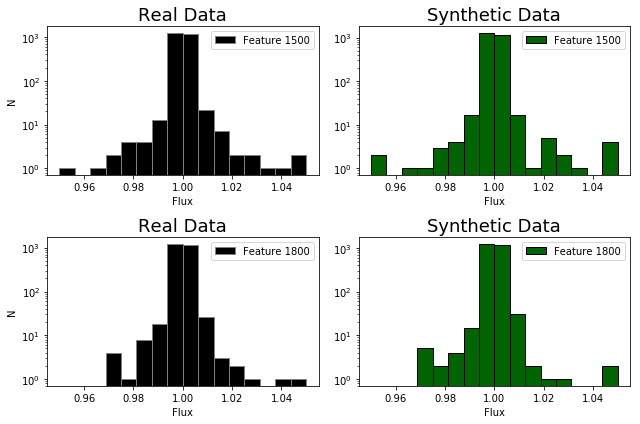

In [40]:
# plots synthetic features against real data checking correct distribution has been achieved.
plt.rcParams['figure.figsize'] = 8, 6
T=[1500,1800]
j=-1
plt.rcParams['figure.figsize'] = 9,6
for i in T:
    j=j+2
    plt.subplot(2,2,j)
    plt.title('Real Data',fontsize=18)
    plt.hist(periodograms[:, i], bins=16,range=(0.95,1.05) ,color="k",edgecolor='grey', label="Feature {}".format(i))
    plt.yscale('log')
    plt.legend(loc='best')
    plt.xlabel('Flux')
    plt.ylabel('N')
    
    plt.subplot(2,2,j+1)
    plt.title('Synthetic Data',fontsize=18)
    plt.hist(X_syn[:, i], bins=16,range=(0.95,1.05), color="darkgreen",edgecolor='black', label="Feature {}".format(i))
    plt.yscale('log')
    plt.xlabel('Flux')
    plt.legend(loc='best')
    
plt.tight_layout()

In [25]:
def merge_work_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving the label "1" to the real data and label "2" to the synthetic data
    """
    # build the labels vector
    Y = numpy.ones(len(X))
    Y_syn = numpy.ones(len(X_syn)) * 2

    Y_total = numpy.concatenate((Y, Y_syn))
    X_total = numpy.concatenate((X, X_syn))
    return X_total, Y_total

X_total, Y_total = merge_work_and_synthetic_samples(periodograms, X_syn)
# declare an RF
N_TRAIN = 100 # number of trees in the forest
rand_f = sklearn.ensemble.RandomForestClassifier(n_estimators=N_TRAIN)
rand_f.fit(X_total, Y_total)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

4534
0.6825584362863153 0.3174415637136846


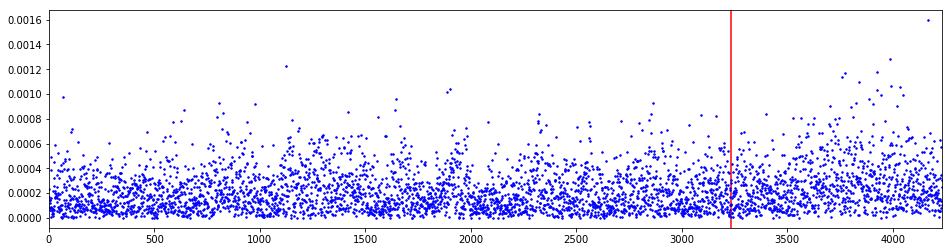

In [26]:
importances = rand_f.feature_importances_
print(len(importances))
feats = arange(len(importances))
plt.rcParams['figure.figsize'] = 16, 4
plt.axvline(x=3234, color='r')
plt.plot(feats,importances,'b.', markersize=3)
xlim(0,4233)
#ylim(0,0.01)
print(np.sum(importances[:3234]),np.sum(importances[3234:]))

In [27]:
# Simlpy records the most/least important features when training the RF forest above.
imp=[]
m=np.sort(importances)
M=m[-10:]
N=m[279:289]

imp=zeros(len(M),dtype=int)
imp_low=zeros(len(M),dtype=int)

for c, value in enumerate(M, 1):
    np.sort(importances)
    for i in range(len(importances)):
        if importances[i]==value:
            imp[c-1]=round(i)

for c, value in enumerate(N, 1):
    np.sort(importances)
    for i in range(len(importances)):
        if importances[i]==value:
            imp_low[c-1]=round(i)
            


imp=imp[::-1]
print(imp)
print(imp_low)

[4170 3988 1124 3928 3776 3760 3840 3992 4035 1900]
[1789 1075 3222 2890 3880 2184  670 2387  293 3512]


In [96]:
light_curves=2500
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """

    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
    # find the predictions of the sample
    is_good_matrix = np.zeros(apply_mat.shape)
    for i, est in enumerate(rand_f.estimators_):
        d = est.predict_proba(X)[:, 0] == 1
        is_good_matrix[:, i] = d
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1
    
    leaf_pop=np.zeros((np.max(apply_mat[:,:]+1),N_TRAIN))
    #creates an array of each leaf population for all trees in RF
    for i in range(light_curves):
        for j in range(N_TRAIN):
            if apply_mat[i,j]!= -1:
                leaf_pop[apply_mat[i,j],j]+=1
                
    #used to normalize and wieght the results heavily towards trees that corretly identify objects as real or synthetic
    Normalization=np.sum(leaf_pop,axis=0)
    Norm_mean=np.mean(Normalization)
    #print('Normalization=',Normalization[20], Norm_mean)
    
    #Reduces each population by 1 to avoid self comparison.
    for i in range(leaf_pop.shape[0]):
        for j in range(N_TRAIN):
            if leaf_pop[i,j]!=0:
                leaf_pop[i,j]-=1
    
    #creates the similarity matrix by using the leaf populations rather then pair matching each light curve
    sim_vec=np.zeros(light_curves)
    for i in range(light_curves):
        for j in range(N_TRAIN):
            sim_vec[i]+=(leaf_pop[(apply_mat[i,j]),j]) #adds normalization here '/Normalization[j]'
    sim_vec/= float(len(sim_vec-1))*N_TRAIN
    return sim_vec
sim_mat = build_similarity_matrix(rand_f, periodograms)
print(sim_mat)
dis_mat=1-sim_mat
print(dis_mat)

[0.048   0.53624 0.35412 ... 0.53068 0.08608 0.10744]
[0.952   0.46376 0.64588 ... 0.46932 0.91392 0.89256]


Text(0.5,0,'Weirdness Score')

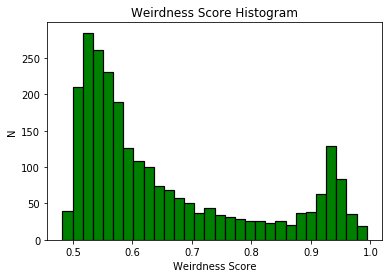

In [42]:
#Plot of Weirdness as a histogram for all objects.
sum_vec=dis_mat
plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness Score Histogram")
tmp = plt.hist(dis_mat, bins=30, color="SteelBlue", edgecolor='black', linewidth=1.2)
plt.ylabel("N")
plt.xlabel("Weirdness Score")
#plt.tight_layout()
#plt.savefig('/home/dcrake/bin/Histograms/Weirdness_Histogram_Combination.pdf', dpi=600)

1
2
3
4


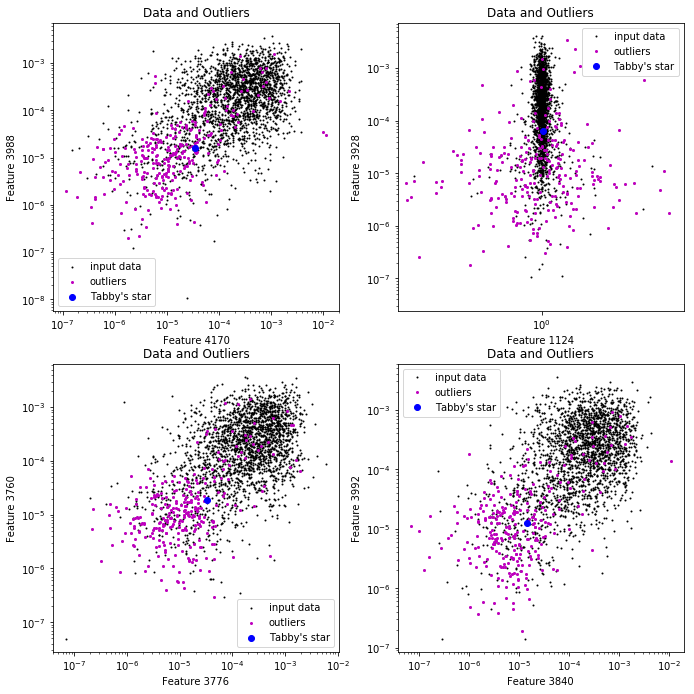

In [44]:

N_outliers = 275
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]

T=imp
j=0
q=-2
plt.rcParams['figure.figsize'] = 10,10
for i in range(0,4):
    j+=1
    q+=2
    plt.subplot(2,2,j)
    plt.title("Data and Outliers")
    print(j)
    plt.plot(periodograms[:,T[q]], periodograms[:,T[q+1]], "ok", label="input data", markersize=1)
    plt.plot(periodograms[obj_ids_outliers, T[q]], periodograms[obj_ids_outliers, T[q+1]], "om", label="outliers", markersize=2)
    plt.plot(periodograms[0,T[q]], periodograms[0,T[q+1]], "ok", label="Tabby's star", markersize=6, color='b')
    plt.xlabel("Feature {}".format(T[q]))
    plt.ylabel("Feature {}".format(T[q+1]))
    plt.legend(loc="best")
    plt.xscale('log')
    plt.yscale('log')
    if i==1: plt.xlim(0.985,1.015)


plt.tight_layout()    
plt.tight_layout(pad=2.0, w_pad=0.2, h_pad=0.2)
# plt.savefig('drives_weirdness.ps',dpi=300,bbox_inches='tight')
# plt.savefig('drives_weirdness.png',dpi=300,bbox_inches='tight')
#plt.savefig('/home/dcrake/bin/Histograms/drives_weirdness.pdf',dpi=300,bbox_inches='tight')

In [48]:
# Creates an array of ordered by Wierdness.
N_outliers = 2500
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]
print (obj_ids_outliers)

[ 363  753 1660 ...  480 2260 1252]


In [101]:
N_outliers = 2500
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]
kep_obj_ids_outliers=[]

for i in range(2500):
    kep_obj_ids_outliers.append(ID[obj_ids_outliers[i]])
    
for c, value in enumerate(obj_ids_outliers):
    if value==0:
        print(c, value)    
        if value==0:
            print("Tabby's Star =",kep_obj_ids_outliers[c])
            if kep_obj_ids_outliers[c] == 'kplr008462852':
                print('TRUE')
            else: print('FALSE')

sum_vec_outliers1 = numpy.sort(sum_vec)[:N_outliers]
obj_ids_outliers1 = obj_ids[numpy.argsort(sum_vec)][:N_outliers]
kep_obj_ids_outliers1=[]
for i in range(2500):
    kep_obj_ids_outliers1.append(ID[obj_ids_outliers1[i]])




254 0
Tabby's Star = kplr008462852
TRUE


982 kplr012057739 PM*
906 kplr007364203 Ro*
1006 kplr009209372 *
1019 kplr007264595 *
1642 kplr012061133 *
2064 kplr005284459 *
2314 kplr005185370 *
910 kplr010471627 *
1015 kplr008456202 Ro*


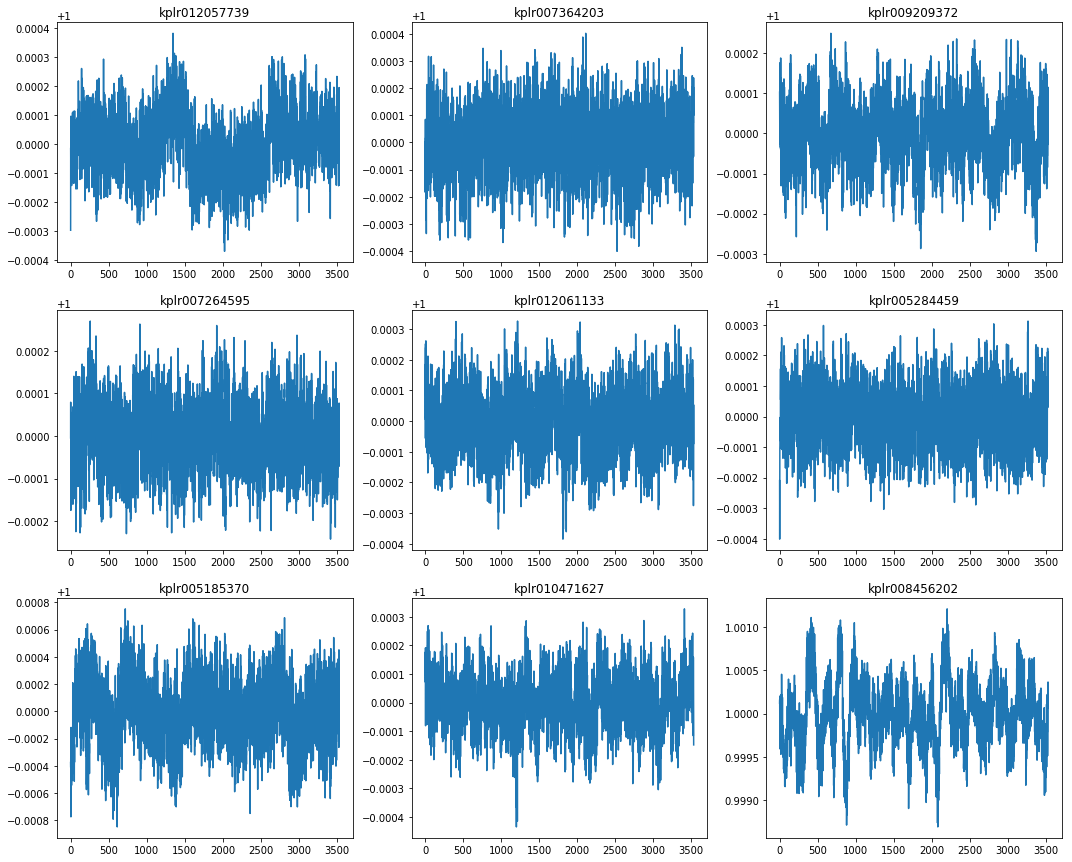

In [102]:
j=0
plt.rcParams['figure.figsize'] = 18,15
s=2400
for i in np.arange(s,s+9):
    print(Observables[obj_ids_outliers[i]][0],Observables[obj_ids_outliers[i]][1],Observables[obj_ids_outliers[i]][-1])
    j+=1
    plt.subplot(3,3,j)
    plt.plot(lcvs[obj_ids_outliers[i]][1][:])
    plt.title("{}".format(Observables[obj_ids_outliers[i]][1]))
    plt.xticks()
    plt.yticks()

# Tabulates the Objects, Categorized by SIMBAD type.

In [61]:
Type=['*','PM*','Ro*','WU*','Er*','Al*','err','RG*','dS*','Pu*','GiC','EB*','Pl?','V*','G','gD*','LP*','WD*','Ce*','**','RR*','SB*','HS*','RB?','Mi*','*iC']
Key=['Star','High Proper-Motion Star','Rotationally Variable Star','Eclipsing binary of W UMa Type','Eruptive variable Star','Eclipsing Binary of Algol Type','Error','Red Giant Branch Star','Variable Star of delta Sct type','Pulsating Variable Star','Galaxy in Cluster of Galaxies','Eclipsing binary','Extra-Solar Planet Candidate','Variable Star','Galaxy','Variable Star of Gamma Dor Type','Long-Period Variable Star','White Dwarf','Cepheid variable Star','Double or Multiple Star','Variable Star of RR Lyr Type','Spectroscopic Binary','Hot Subdwarf','Possible Red Giant Branch Star','Variable Star of Mira Cet Type','Star in Cluster']

Sum=0
Count=np.zeros(len(Type),dtype=int)
for i in range(len(Observables)):
    Sum_prev=Sum
    for j in range(len(Type)):
        if Observables[i][5]==Type[j]: Count[j]+=1
    Sum=np.sum(Count)

Type_Frequency=pd.DataFrame({'Symbol': Type,'Type':Key,'Number': Count})
Type_Frequency.sort_values(by=['Number'], ascending=False)

,Symbol,Type,Number
0,*,Star,1778
2,Ro*,Rotationally Variable Star,479
7,RG*,Red Giant Branch Star,73
1,PM*,High Proper-Motion Star,33
11,EB*,Eclipsing binary,25
4,Er*,Eruptive variable Star,24
5,Al*,Eclipsing Binary of Algol Type,17
14,G,Galaxy,11
8,dS*,Variable Star of delta Sct type,10
3,WU*,Eclipsing binary of W UMa Type,9


# Runs the RF Algorithm over N repeats, using both Periodograms and Fluxes as features

In [153]:
# Run the algorithm N times, 
import time
obs_ids_outliers_all = []
obs_ids_outliers1_all = []
scores_more = []
scores_less = []
start=time.time()
Weirdness=np.zeros((2500,2))

for i in range(10): # N
    print(i,time.time()-start)
    X_syn = return_synthetic_data(periodograms)
    X_total, Y_total = merge_work_and_synthetic_samples(periodograms, X_syn)
    # declare an RF
    N_TRAIN = 100 # number of trees in the forest
    rand_f = sklearn.ensemble.RandomForestClassifier(n_estimators=N_TRAIN)
    rand_f.fit(X_total, Y_total)
    # Build sim_matrix
    sim_mat = build_similarity_matrix(rand_f, periodograms)
    dis_mat=1-sim_mat
    sum_vec=dis_mat
    N_outliers=100    
    sum_vec_outliers = np.sort(sum_vec)[::-1][:N_outliers]
    scores_more.append(sum_vec_outliers)
    obs_ids_outliers_all.append(obj_ids[np.argsort(sum_vec)][::-1][:N_outliers])
    sum_vec_outliers1 = np.sort(sum_vec)[:N_outliers]
    scores_less.append(sum_vec_outliers1)
    obs_ids_outliers1_all.append(obj_ids[np.argsort(sum_vec)][:N_outliers])
    for j in range(2500):
        Weirdness[j][0]+=dis_mat[j]
        if i==9:
            Weirdness[j][0]/=10
        Weirdness[j][1]=int(j)
end=time.time()-start
print('Time elapsed =',end,'seconds')
print (np.shape(obs_ids_outliers_all))

0 0.00032711029052734375
1 62.07974576950073
2 125.0346691608429
3 184.4935541152954
4 242.34472584724426
5 302.043256521225
6 362.49106073379517
7 421.66631293296814
8 480.51075077056885
9 540.0914454460144
Time elapsed = 600.0438117980957 seconds
(10, 100)


In [154]:
# Sorts objects by average weirdness over all repeats.
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
Weirdness=Weirdness[Weirdness[:,0].argsort()]
print(Weirdness)
final_ids=(Weirdness[:,1])

[[0.474228 1837.000000]
 [0.475688 1731.000000]
 [0.475691 606.000000]
 ...
 [0.987346 24.000000]
 [0.988824 1781.000000]
 [0.989131 1560.000000]]


Text(0.5,0,'Weirdness Score')

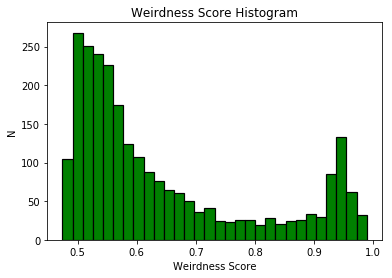

In [155]:
plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness Score Histogram")
tmp = plt.hist(Weirdness[:,0], bins=30, color="g", edgecolor='black', linewidth=1.2)
plt.ylabel("N")
plt.xlabel("Weirdness Score")

In [135]:
# N_outliers = 2500
# sum_vec_outliers = numpy.sort(Weirdness[:,0])[::-1][:N_outliers]
# obj_ids_outliers = obj_ids[numpy.argsort(Weirdness[:,0])][::-1][:N_outliers]

516 kplr008940939 BD+45 2833 0
2201 kplr008570955 KIC8570955 0
1097 kplr007511916 TYC3132-967-1 0
576 kplr010921983 LEDA2315444 0
1252 kplr007744818 KIC7744818 0
1993 kplr008573731 2MASSJ19464436+4441040 0
606 kplr009220611 TYC3556-3039-1 0
1731 kplr004936750 NGC 6819 0
1837 kplr006751930 2MASSJ18472624+4214351 0


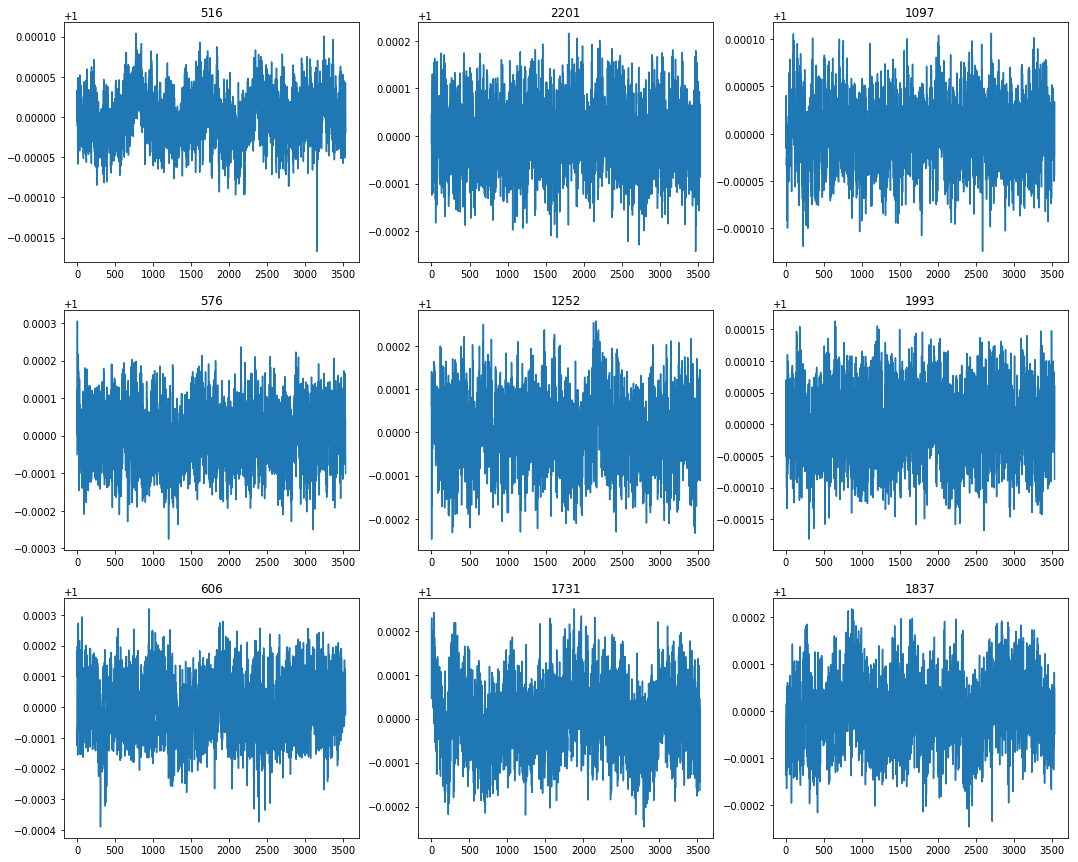

In [181]:
j=0
plt.rcParams['figure.figsize'] = 18,15
s=2492
for i in np.arange(s,s+9):
    print(Observables[int(final_ids[-i])][0],Observables[int(final_ids[-i])][1],Observables[int(final_ids[-i])][4],Observables[int(final_ids[-i])][-1])
    j+=1
    plt.subplot(3,3,j)
    #plt.plot(lcvs[obj_ids_outliers[i]][0][a:],lcvs[obj_ids_outliers[i]][1][a:])
    plt.plot(lcvs[int(final_ids[-i])][1][:])
    plt.title("{}".format(Observables[int(final_ids[-i])][0]))
    plt.xticks()
    plt.yticks()

In [165]:
'''Creates a table highlighting the number of each type of object in the weirdest 100 list. This number of compared to 
the expected number in a list of 100 randomly selected objects from the total population. This table can be used to analyse 
the type of objects each method identifies as 'Weird'.'''
Weirdest_Count_all=np.zeros(len(Type),dtype=int)
Least_Weird_Count_all=np.zeros(len(Type),dtype=int)
Percentage_all=[]
Identity_all=[]
Perc=np.zeros(len(Type))
N_Outliers=100
for i in range(N_Outliers):
    Identity_all.append(Observables[int(final_ids[-i])][4])
    for j in range(len(Type)):
        if Observables[int(final_ids[-i])][5]==Type[j]:
            Weirdest_Count_all[j]+=1

for i in range(len(Type)):    
    Percentage_all.append(round(Weirdest_Count_all[i]*100/Count[i],2))    
for i in range(len(Type)):
    Perc[i]=round(Count[i]*N_Outliers/2500,2)
    
Weird_Frequency=pd.DataFrame({'Symbol': Type,'Type':Key,'Number': Count,'Percentage Identified':Percentage_all,'Identified': Weirdest_Count_all,'Random Selection':Perc})
Weird_Frequency.sort_values(by=['Percentage Identified'], ascending=False)

,Symbol,Type,Number,Percentage Identified,Identified,Random Selection
18,Ce*,Cepheid variable Star,1,100.00,1,0.04
15,gD*,Variable Star of Gamma Dor Type,2,100.00,2,0.08
3,WU*,Eclipsing binary of W UMa Type,9,100.00,9,0.36
20,RR*,Variable Star of RR Lyr Type,2,100.00,2,0.08
22,HS*,Hot Subdwarf,1,100.00,1,0.04
9,Pu*,Pulsating Variable Star,3,66.67,2,0.12
12,Pl?,Extra-Solar Planet Candidate,2,50.00,1,0.08
8,dS*,Variable Star of delta Sct type,10,50.00,5,0.40
4,Er*,Eruptive variable Star,24,37.50,9,0.96
5,Al*,Eclipsing Binary of Algol Type,17,35.29,6,0.68
